# Memory-based Collaborative Filtering using KNN

Collaborative filtering methods work on a table of *U* users who can rate *I* items.  
The prediction *p* of a non-rated item *i* for a user *u* ($p_{u,i}$) is computed as an aggregate of the ratings of the *K* most similar users (*k*-neighbors) for the same item *i*.

$$
p_{u,i} =
\bar{r}_u +
\frac
{ \sum\limits_{ n \in N_{u,i} } sim(u,n) \cdot (r_{n,i} - \bar{r}_n) }
{ \sum\limits_{ n \in N_{u,i} } sim(u,n) }
$$

$\bar{r}_u$ is the average rating of user *u*,  
$sim(u,n)$ is the similarity between user *u* and user *n*,  
$N_{u,i}$ are the neighbors of user *u* who have voted the item *i*,  
$r_{n,i}$ is the rating of user *n* on item *i*,  
$\bar{r}_n$ is the average rating of user *n*.

### Loading the dataset
We are using the **Movielens 100K Dataset**, saving it into a dictionary of dictionaries.  
The keys of the first dictionary are the user codes and the keys of the second dictionary are the item codes.

In [1]:
dataset = {}

file = open("movielens100k.ratings", "r") 
for line in file:
    [user, movie, rating, ts] = line.split("\t") # tab separated
    
    if user not in dataset:
        dataset[user] = {}
        
    dataset[user][movie] = int(rating)

In [2]:
users = dataset.keys()
movies = []
ratings = []
for m in dataset.values():
    for movie, rating in m.items():
        if movie not in movies:
            movies.append(movie)
        ratings.append(rating)
print("Number of users in dataset: ", len(users))
print("Number of movies in dataset: ", len(movies))

Number of users in dataset:  943
Number of movies in dataset:  1682


### Distribution of ratings

In [3]:
from collections import Counter
Counter(ratings)

Counter({1: 6110, 2: 11370, 3: 27145, 4: 34174, 5: 21201})

### Average ratings

In [4]:
import numpy as np

average_ratings = {}
for user, movies in dataset.items():
    average_ratings[user] = (np.mean(list(movies.values())))

### MSD
To calculate the similarity between two users we first calculate the Mean of the Squared Differences of the ratings of the movies that have been rated by both users, $MSD(x,y)$:

In [5]:
def msd (ratings_1, ratings_2):
    d = 0
    c = 0
    
    for item, r1 in ratings_1.items():
        if item in ratings_2:
            r2 = ratings_2[item]
            d += (r1 - r2)**2 / 4**2   # we standardize values of d to [0, 1]
            c += 1

    return d / c   # MSD(x, y)

### Jaccard
Next we obtain the Jaccard(*x*,*y*) measure computing the proportion between the intersection and the union of the sets of items rated by user *x* and user *y*:
$$ Jaccard(x,y) = \frac {r_x \cap r_y} {r_x \cup r_y} $$
The Jaccard index is also known as Intersection over Union (IoU) and measures similarity between finite sample sets.

In [6]:
def jaccard (ratings_1, ratings_2):
    intersection = 0
    for item in ratings_1:
        if item in ratings_2:
            intersection += 1
    return intersection / (len(ratings_1) + len(ratings_2) - intersection)   # Jaccard(x, y)

### Similarity metric
We combine MSD and Jaccard to get our similarity metric:  
$$ Sim(x,y) = Jaccard(x,y) \times (1 - MSD(x,y)) $$

In [7]:
def has_common_ratings (ratings_1, ratings_2):
    for item in ratings_1:
        if item in ratings_2:
            return True
    return False

In [8]:
def sim (active_user, active_user_ratings):

    similarities = {}

    for user, ratings in dataset.items():
        if user == active_user: continue

        if not has_common_ratings(active_user_ratings, ratings): continue

        j = jaccard(active_user_ratings, ratings)
        m = msd(active_user_ratings, ratings)

        similarities[user] = j * (1 - m)
        
    return similarities

### KNN
Using the similarity metric defined above we can calculate the k nearest neighbors:

In [9]:
def knn (active_user, active_user_ratings, k):

    similarities = sim(active_user, active_user_ratings)
    neighbors = {}

    for _ in range(k):    
        max_similarity = 0
        neighbor = None

        for user, similarity in similarities.items():
            if user not in neighbors and similarity > max_similarity:
                max_similarity = similarity
                neighbor = user

        neighbors[neighbor] = max_similarity
        
    return neighbors

### Predictions
Using the ratings of the k nearest neighbors we can make predict ratings for movies the active user has not seen yet, if at least one of the neighbors has rated the movie. The formula was:
$$
p_{u,i} =
\bar{r}_u +
\frac
{ \sum\limits_{ n \in N_{u,i} } sim(u,n) \cdot (r_{n,i} - \bar{r}_n) }
{ \sum\limits_{ n \in N_{u,i} } sim(u,n) }
$$

In [10]:
def predict_ratings (active_user, active_user_ratings, k):

    neighbors = knn(active_user, active_user_ratings, k)
    items = []

    for user in neighbors:
        for item in dataset[user]:
            if item not in items and item not in dataset[active_user]:
                items.append(item)

    r_u = average_ratings[active_user]
    predictions = {}

    for item in items:
        num = 0
        den = 0

        for user, similarity in neighbors.items():
            if item in dataset[user]:
                rating = dataset[user][item]
                r_n = average_ratings[user]
                num += similarity * (rating - r_n)
                den += similarity

        prediction = r_u + num / den

        predictions[item] = prediction
        
    return predictions

### Recommendations
Now we pick the highest predictions to recommend new movies to the active user

In [11]:
def recommend_movies (active_user, active_user_ratings, k, n):

    predictions = predict_ratings(active_user, active_user_ratings, k)
    recommendations = {}

    for _ in range(n):
        max_prediction = 0
        best_item = None

        for item, prediction in predictions.items():
            if prediction > max_prediction and item not in recommendations:
                max_prediction = prediction
                best_item = item

        recommendations[best_item] = max_prediction
        
    return recommendations

### Recommendations for user 1

In [12]:
active_user = "1"
active_user_ratings = dataset[active_user]
k = 100   # using 100 neighbors
n = 50   # 50 recommendations

In [13]:
recommendations = recommend_movies (active_user, active_user_ratings, k, n)

In [14]:
import pandas as pd

pd.DataFrame(list(recommendations.items()), columns=['Movie', 'Prediction'])

,Movie,Prediction
0,1449,5.585084
1,1367,5.330791
2,1629,5.262309
3,1589,5.174711
4,1467,5.115552
5,1599,5.028545
6,1143,4.939457
7,1159,4.904739
8,1516,4.764452
9,1189,4.764452


### Analysing the results
Let's take a closer look at these recommendations for user 1. How many neigbors have rated each movie? What was their rating for this movie, what is their average rating and what is their similarity with user 1?

In [17]:
predictions = predict_ratings(active_user, active_user_ratings, k)
neighbors = knn(active_user, active_user_ratings, k)
similarities = sim(active_user, active_user_ratings)

for movie in recommendations.keys():

    print("movie:", movie, "( prediction: %0.2f" % predictions[movie], ")")
    count = 0
    for neighbor in neighbors.keys():
        if movie in dataset[neighbor]:
            print("user: %s, rating: %i, r_n: %0.2f, sim: %0.2f" %
                  (neighbor,
                   dataset[neighbor][movie],
                   average_ratings[neighbor],
                   similarities[neighbor]))
        else:
            count += 1

    print(count, "neighbors didn't watch this movie")
    print()

movie: 1449 ( prediction: 5.59 )
user: 561, rating: 5, r_n: 3.03, sim: 0.27
99 neighbors didn't watch this movie

movie: 1367 ( prediction: 5.33 )
user: 773, rating: 5, r_n: 3.28, sim: 0.23
99 neighbors didn't watch this movie

movie: 1629 ( prediction: 5.26 )
user: 805, rating: 5, r_n: 3.35, sim: 0.25
99 neighbors didn't watch this movie

movie: 1589 ( prediction: 5.17 )
user: 889, rating: 5, r_n: 3.44, sim: 0.28
99 neighbors didn't watch this movie

movie: 1467 ( prediction: 5.12 )
user: 886, rating: 5, r_n: 3.36, sim: 0.29
user: 244, rating: 5, r_n: 3.65, sim: 0.24
98 neighbors didn't watch this movie

movie: 1599 ( prediction: 5.03 )
user: 437, rating: 5, r_n: 3.58, sim: 0.24
99 neighbors didn't watch this movie

movie: 1143 ( prediction: 4.94 )
user: 387, rating: 5, r_n: 3.36, sim: 0.28
user: 758, rating: 5, r_n: 3.88, sim: 0.26
user: 592, rating: 5, r_n: 3.81, sim: 0.24
97 neighbors didn't watch this movie

movie: 1159 ( prediction: 4.90 )
user: 758, rating: 5, r_n: 3.88, sim: 0.

Looking at these stats we see that the first 4 recommendations are bases only on 1 neighbor's opinion.  
But for example the prediction of movie '1007' is based on 10 neighbors, the prediction is quite high, but it ends up being the 12th recommendation. So we could argue that this recommendation is more stable (less variance).  
Although Movielens may be interested in recommending movies that haven't been watched a lot, so people start renting more movies.

### Nearest neighbors of user 1

In [55]:
import operator

sorted_neighbors = sorted(neighbors.items(), key=operator.itemgetter(1), reverse=True)
sorted_neighbors[0:5]

[('916', 0.33381336405529954),
 ('92', 0.31262729124236255),
 ('864', 0.3123518957345972),
 ('268', 0.311241610738255),
 ('301', 0.30775122549019607)]

Looking at the nearest neighbor, user 916, how is this similarity of 0.33 with user 1 being calculated?

In [47]:
nearest_neighbor = "916"
nearest_neighbor_ratings = dataset[nearest_neighbor]

In [49]:
print("1 - MSD(user_1, user_916):", round(1 - msd(active_user_ratings, nearest_neighbor_ratings), 3))

1 - MSD(user_1, user_916): 0.935


So user 1 and user 916 have a high degree of agreement on their ratings of movies that they both watched. But what is the IoU of these comon movies? 

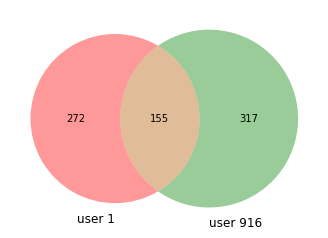

In [54]:
from matplotlib_venn import venn2

intersection = 0
for item in active_user_ratings:
    if item in nearest_neighbor_ratings:
        intersection += 1
        
_ = venn2(subsets = (len(active_user_ratings), len(nearest_neighbor_ratings), intersection),
         set_labels = ['user 1', 'user 916'])

In [52]:
print("Jaccard(user_1, user_916):", round(jaccard(active_user_ratings, nearest_neighbor_ratings), 3))

Jaccard(user_1, user_916): 0.357


When we multiply 0.935 with 0.357 we get the similarity metric of 0.33